# CVA Calculation for an Interest Rate Swap

- Calculate the credit valuation adjustment to the price of an interest rate swap using the credit spreads for Counterparty B.
- Plot MtM values (a good plot will show results from many simulations)
- Produce smoothed Expected Exposure prodile using the mean of the exposure distribution - distribution of Forward LIBORs at each time $T_i+1$.
- Produce Potential Future Exposure with the simulated $L_6M$ taken from the $97.5^{th}$ percentile.

The details for the IRS are as follows:

Recovery Rate = 40%

Tenor = 5Y

Payments Frequency = 6M

MtM Position = Floating Leg - Fixed Leg

We will need to compute:

- Fwd LIBOR rates (via monte carlo)
- Discount Factors
- Exposure
- Expected Exposure

And once we have all of those parts we will be able to determine the CVA (Credit Valuation Adjustment) for the interest rate swap outlined above.

### Forward LIBOR via Monte Carlo

To provide the $L_6M$ structure, we will generate the Forward LIBOR using _One Factor Libor Market Model_, described in 'Advanced Quantative Finance', Alonso Peña. 

I have a particular interest in parallel and GPU based computing so I took it as an opportunity to rewrite the reference material in Python to aid integration with the CUDA GPU library provided by nVidia (https://developer.nvidia.com/cuda-toolkit) and explore the possibilities of performance improvements offered by pyCUDA and the Intel MKL libraries for optimized Math functions on intel processors. These are conveniently provided by the default install of Anaconda (http://www.continuum.io) and are utilitised under the thirty day free trial. 


In [3]:
import numpy as np
import accelerate as acc
from app.gpuCheck import getGpuCount

from accelerate.cuda.rand import PRNG, QRNG

gpuEnabled = False # gpu acceleration is not available in jupyter..
debug = False # code here is pretty much commented so set to false here..

# print 'Checking for compatible GPU ...'
# if getGpuCount() < 1:
#     print 'no compatible GPU installed, will revert to using numpy libraries for RNG'
# else:
#     print 'nVidia GPU(s) found: ', getGpuCount()
#     print 'Enabling GPU for RNG'
#     gpuEnabled = True

The notebook itself runs the normal versions of this, if you are interested in running the GPU enabled versions. You will need an NVidia GFX card with compute capability of greater than 2.0 and have installed the latest cuda drivers. Once installed you can run the python files from disk. Cuda code is included but commented out in the notebook, since it can cause kernel panics and is somewhat unstable when running in an iPython environment (web hosted environment, where inclusion of nVdia hardware is not necessarily gauranteed.

### Calculate Credit Default Swap Spreads

In order to infer the correct lambda to use, we need to calculate the spread value for the CDS. 

So for the value of the default leg, we will use:

$PV(default) = \sum_{i=1}^{T_i}N . (1-R) . DF_i . PD(T_i,T_{i-1}) $

$PV(premium) = \sum_{i=1}^{T_i} \pi . N . \Delta t . DF_i . PD(T_i) $

Bootstrapping the hazard rates using the formula below:

$\lambda_k = \frac{-1}{\Delta t} ln ( \frac{P(T_{k-1}D(0,T_k)(1-R)+\sum{n=1}^{k-1}}{} ) $

#### Discount Factors
The following formula has been used to derive the discount factors:

$DF_i = exp(-S_iT_i)$

#### Default Probabilities
The following formula has been used to derive the default probablities:

$PD_i = exp(-\lambda T_{i-1}) -exp(-\lambda T_i)\quad \forall i = 1,2,3,4$

#### Forward Rates
next we need the forward rates and the discount factors.

$L_I = S_I$

$L_1 = \frac{S_iT_i - S_{i-1}T_{i-1}}{T_i-T_{i-1}}$

Forward rates can be derived from the spot rates in continous time.

To encapsulate this I have created the CDS class below, we will import it here and its uses follows.

```python
from math import isnan

from numpy import array, ones, zeros, exp, put, sum, mean, percentile, append
from pandas import DataFrame

from utils import getTPlusFromList

debug = False


class CreditDefaultSwap(object):
    """
    enter spread value in normal number and NOT in basis points
    TODO - allow input of basis points for spread
    """

    def __init__(self,
                 N=float,
                 timesteps=list,
                 discountFactors=list,
                 lamda=float,
                 spread=float('nan'),
                 Dt=0.5,
                 recoveryRate=0.4,
                 llamda=list):
        self.N = N  # notional
        self.__lamda = lamda
        self.__seed = spread
        self.recoveryRate = recoveryRate
        self.Dt = Dt
        self.__timesteps = timesteps
        self.discountFactors = discountFactors

        # if llamda is list and len(llamda) > 0:
        #     self.pT = self.generateProbSurvivalTS()
        #     self.premiumLegsSpread = self.calculatePremiumLegSpreadsTS()
        # else:
        self.pT = self.generateProbSurvival()
        self.premiumLegsSpread = self.calculatePremiumLegValues()

        self.__premiumLegSum = sum(self.premiumLegsSpread)
        self.pD = self.generateProbDefault()
        self.defaultLegsSpread = self.calculateDefaultLegValues()
        self.__defaultLegSum = sum(self.defaultLegsSpread)
        self.fairSpread = self.premiumLegsSpread / self.defaultLegsSpread
        self.__expectedExposure = []

    @property
    def premiumLegSum(self):
        return self.__premiumLegSum

    @property
    def defaultLegSum(self):
        return self.__defaultLegSum

    @property
    def markToMarket(self):
        return self.__premiumLegSum - self.__defaultLegSum

    @property
    def lamda(self):
        return self.__lamda

    @property
    def seed(self):
        return self.__seed

    @property
    def timesteps(self):
        return self.__timesteps

    def generateDiscountFactors(self):
        pass

    def generateProbSurvival(self):
        """
        using $\exp^{-\lambda*T_i}$
        :return:
        """
        pt = ones(len(self.timesteps))
        for index, t in enumerate(self.timesteps):
            ps = exp(self.lamda * -1 * t) if index > 0 else 1.0
            put(pt, index, ps)
        return pt

    def generateProbDefault(self):
        """
        using $P(T,0) = P_{i-1} - P_i$
        :return:
        """
        pd = zeros(len(self.timesteps))
        for index, pt in enumerate(self.pT):
            pdi = self.pT[index - 1] - pt if index > 0 else 0.0
            put(pd, index, pdi)

        return pd

    def calculatePremiumLegValues(self, withAccruals=False):
        """
        returns the list of the premium leg values
        :return: array
        """
        #          assume 1%
        values = zeros(len(self.timesteps))

        for index, (df, pt, pd) in enumerate(zip(self.discountFactors, self.pT, self.pD)):
            if index > 0:
                pv = (self.N * self.Dt * df * pt) * (self.lamda if isnan(self.seed) else self.seed)
                if withAccruals:
                    # $ +D(0,T_n)(P(T_{n-1}) - P(T_n)) \frac{\Delta t_n}{2} $
                    pv += pd * self.Dt * 0.5
                put(values, index, pv)
        return values

    def calculateDefaultLegValues(self):
        """
        returns the list of the default leg values
        :return: array
        """
        #          assume 1%
        spreads = zeros(len(self.timesteps))
        for index, (df, pd) in enumerate(zip(self.discountFactors, self.pD)):
            if index > 0:
                spread = self.N * (1 - self.recoveryRate) * df * pd
                put(spreads, index, spread)
        return spreads

    def calcCVA(self, mtm=array, expectedExposure=array):
        cvaData = DataFrame()
        cvaData['t'] = self.timesteps
        cvaData['discountFactor'] = self.discountFactors
        cvaData['pSurvival'] = self.pT
        cvaData['pDefault'] = self.pD
        cvaData['mtm'] = mtm
        cvaData['1-R'] = [1 - self.recoveryRate] * len(self.pD)
        cvaData['exposure'] = [getTPlusFromList(expectedExposure, i, True) for i in range(len(expectedExposure))]
        cvaData['cvaPerTimeStep'] = cvaData['discountFactor'] * cvaData['pDefault'] * cvaData['1-R'] * cvaData[
            'exposure']
        cva = cvaData['cvaPerTimeStep'].sum()
        print cvaData
        # print 'CVA = ', cva
        return cva

    def calcBVA(self, eeA=array, eeB=array):
        # LAST BIT TO DO
        return True

    def getExpectedExposureA(self, simData=array):
        expectedExposure = mean(array([sim.expA for sim in simData]), axis=0)
        return append(expectedExposure, 0.0)

    def getExpectedExposureB(self, simData=array):
        expectedExposure = mean(array([sim.expB for sim in simData]), axis=0)
        return append(expectedExposure, 0.0)

    def getPercentile(self, simData=array, p=float):
        ptile = percentile(array([sim.mtm for sim in simData]), q=p, axis=0)
        return append(ptile, 0.0)

    def getExpectedMTM(self, simData=array):
        expected_mtm = mean(array([sim.mtm for sim in simData]), axis=0)
        return append(expected_mtm, 0.0)

class Simulation(object):
    """
    this class is used a container for a single simulation
    providing convenenience methods to retrieve
    markToMarket values
    eeA = expected exposure from the simulation for Counterparty A
    eeB = expected exposure from the simulation for Counterparty B
    default fixed rate is set to current BoE base rate
    """

    def __init__(self, lbT=array, dfTable=array, notional=1000000, dt=0.25, k=0.004):
        """

        :type k: float
        :type dt: float
        :type notional: float
        :type dfTable: ndarray
        :type lbT: ndarray
        """
        self.liborTable = lbT

        self.dfTable = dfTable
        self.dt = dt

        # calculate payments for each timestep using the given notional, tenor, fixed rate,
        # floating(simulated) and discount factors (simulated)
        self.payments = self.calcPayments(notional, self.dt, k)

        self.mtm = array([flt - fxd for flt, fxd in self.payments])

        # exposure for counterParty A (using positive mtm)
        self.expA = array([max(L - K, 0) for L, K in self.payments])

        # exposure for counterParty B (using negative mtm)
        self.expB = array([min(L - K, 0) for L, K in self.payments])

    def calcPayments(self, notional=float, dt=float, fixed=-1.0):
        global debug
        """
        calculate payments for the simulation of the Fwd rates and discount factors
        given notional and tenor

        :param notional:
        :param dt:
        :param fixed:
        :return: float
        """
        payments = []

        for index in range(0, len(self.liborTable)):
            fwdCurve = self.liborTable[:, index]
            df = self.dfTable[1:, index]

            floatingLeg = [fwd * dfi * notional * dt for fwd, dfi in zip(fwdCurve, df)]
            fixedLeg = [fixed * dfi * notional * dt for dfi in df]
            # fixedLeg[len(self.__liborTable)] = 0
            payments.append([sum(floatingLeg), sum(fixedLeg)])

            if debug:
                print 'from t-', index, '--- fixed - ', sum(fixedLeg), '--- floating -', sum(
                    floatingLeg), '-- mtm --', sum(floatingLeg) - sum(fixedLeg)
                print fixedLeg
                print '--'
                print floatingLeg
                print '--'

        return payments


def genDiscountFactors(t=list, s=list):
    discount = [float('nan')]

    for (ti, si) in zip(t[1:], s):
        DFi = exp(si * ti * -1)
        discount.append(DFi)

    return discount


# plot tbis against reference curve
def genFwdCurve(t=list, s=list):
    curve = []

    for i, (ti, si) in enumerate(zip(t, s)):
        sim1 = s[i - 1] if i > 0 else 0.0
        tim1 = t[i - 1] if i > 0 else 0.0
        Li = ((si * ti) - (sim1 * tim1)) / (ti - tim1) if i > 0 else 0.0
        curve.append(Li)
    return curve


if __name__ == "__main__":
    print 'Testing Basket Default Swap'

    # df = [0.9803, 0.9514, 0.9159, 0.8756, 0.8328]
    # seed = 0.01
    # payments = 4
    # notional = 1000000
    # # fixed hazard rates
    # lamda = 0.03
    #
    # b = BasketCDS(N=notional, timesteps=5, discountFactors=df, lamda=lamda, dt=1.0, seed=seed,)
    # b.recoveryRate = 0.5
    # b.buildFlatTermStructure([57]*5)



```

We need to now compute what is the value that should be used. So by using an optimising algorithm we can minimise the value of markToMarket to 0. This will then give us the value that we should use for the hazard rate $\lambda$.

In [4]:
import time

from numpy import array, linspace
from scipy.optimize import fsolve

import app.CreditDefaultSwap as cds
import app.rng as rng
from app.LMM1F import LMM1F
from app.utils import printTime

gpuEnabled = False


# pushing the size of rng generated above 100000 causes GPU to run out of space
# possible optimisation is to load it into a 3d vector shape instead of flat structure.

def initRandSource():
    randN = 100000
    randSourceGPU = rng.getPseudoRandomNumbers_Uniform_cuda(randN) if gpuEnabled else []
    randSourceCPU = rng.getPseudoRandomNumbers_Uniform(randN)
    return randSourceGPU if gpuEnabled else randSourceCPU


randSource = initRandSource()

debug = False

# 5Y tenor
noOfYears = 5.
# 6M payments
paymentFrequency = 0.5
yearFraction = paymentFrequency / noOfYears
noOfPayments = noOfYears / paymentFrequency

# no of timesteps
timesteps = linspace(0, 1, noOfPayments + 1)

n = 100
# initRates = array([0.01, 0.03, 0.04, 0.05, 0.07])

# irEx = LMM1F(nSims=n, initialSpotRates=initRates, notional=1000000, randSource=randSource)
# start_time = time.clock()
# a = irEx.getSimulationData()
# printTime('GPU: generating simulation data', start_time)

# test vars
testRates = array([0.01, 0.03, 0.05, 0.07])
df = [0.0, 0.9975, 0.9900, 0.9778, 0.9608]

# BOE spot curve
initRates_BOE_6m = [0.423546874, 0.425980925, 0.45950348, 0.501875772, 0.551473011, 0.585741857, 0.626315731,
                    0.667316554, 0.709477279, 0.753122018]

# scale the curve above since it is quote in %
initRates_BOE_6m_scaled = [x * 1 / 100. for x in initRates_BOE_6m]
BOE_6m_discountFactors = cds.genDiscountFactors(timesteps, initRates_BOE_6m_scaled)
BOE_6m_fwdCurve = cds.genFwdCurve(timesteps, initRates_BOE_6m_scaled)
seed = 0.01
notional = 1000000

# fixed hazard rate
lamda = 0.03

# before calibration
f = cds.CreditDefaultSwap(N=notional, 
                          timesteps=timesteps, 
                          discountFactors=BOE_6m_discountFactors, 
                          lamda=lamda)

print 'MTM before calibration ', f.markToMarket, '\n'


MTM before calibration  129372.932372 



In [5]:
# we use 'seed' as our intial guess for the optimisation, the premium leg needs to be calibrated

def calibrateCDS(lamda=float, seed=0.01):
    # calibration method
    e = cds.CreditDefaultSwap(N=notional, 
                              timesteps=timesteps, 
                              discountFactors=BOE_6m_discountFactors, 
                              lamda=lamda, 
                              spread=seed)
    return e.markToMarket

# then use the fsolve method from SciPy
optimisation = fsolve(calibrateCDS, x0=[lamda], full_output=True)


The optimisation routine is provided by parts of the SciPy Optimize library, so we will need to import this. it needs to be wrapped in function so that the optimiser is able to call it with different values. The fSolve function is a wrapper around MINPACK's hybrd and hybrj algorithms. https://en.wikipedia.org/wiki/MINPACK

In [6]:
print '================'
print 'Calibration Results using seed of ', seed
print 'value:\t\t\t', optimisation[0]
print 'iterations:\t', optimisation[1]['nfev']
print optimisation[3], '\n'

calibratedLambda = optimisation[0]
# then set seed to be the same value as the calibrated lambda value
f = cds.CreditDefaultSwap(N=notional, 
                          timesteps=timesteps, 
                          discountFactors=BOE_6m_discountFactors, 
                          lamda=lamda)

Calibration Results using seed of  0.01
value:			[ 0.08298803]
iterations:	7
The solution converged. 



Approximate spread of Counterparty B is 82.9 basis points.

## Random Number Generation

In order to facilitate simplified random number generation, it seemed appropriate to setup a utilty class to do this. It has also given the opportunity to explore the ability to use the GPU for both Pseudo Random Number Generation and Quasi Random Number Generation.

Additional libraries:

ghalton - https://github.com/fmder/ghalton

sobol_seq - https://github.com/naught101/sobol_seq

conda (package manager for Anaconda) does not install these properly so it is best to just clone and install it in the normal python way:

```python
cd itemToInstall/
python setup.py build
python setup.py test #(sometimes this fails, when no tests have been written)
python setup.py install #(sometimes requires admin privs depending on way python has been installed)]
```

these items are included on the usb drives.

```python
import ghalton
import sobol_seq
from accelerate.cuda.rand import PRNG, QRNG
from numpy import array, empty, random, square, log, sqrt


def getPseudoRandomNumbers_Uniform(length=int):
    """

    generates a an array of psuedo random numbers from uniform distribution using numpy

    :param length:
    :return:
    """
    return random.uniform(size=length)


def getPseudoRandomNumbers_Uniform_cuda(length=int):
    # type: (object) -> object
    """

    generates a an array of psuedo random numbers from uniform distribution using CUDA

    :rtype: ndarray
    :param length:
    :return:
    """
    prng = PRNG(rndtype=PRNG.XORWOW)
    rand = empty(length)
    prng.uniform(rand)

    return rand


def getPseudoRandomNumbers_Standard(shape=tuple):
    """

    generates a an array of psuedo random numbers from standard normal distribution using numpy

    :param length:
    :return:
    """
    return random.normal(size=shape)


def getPseudoRandomNumbers_Standard_cuda(shape=tuple):
    # type: (object) -> object
    """

    generates a an array of psuedo random numbers from standard normal distribution using CUDA

    :rtype: ndarray
    :param length:
    :return:
    """
    prng = PRNG(rndtype=PRNG.XORWOW)
    rand = empty(shape)
    prng.normal(rand, 0, 1)

    return rand


def getSOBOLseq_standard(shape=tuple):
    """
    generate a SOBOL sequence
    
    :param shape: tuple of row, column of the desired return matrix
    :return:
    """
    return sobol_seq.i4_sobol_generate_std_normal(shape)


# def getSOBOLseq_uniform(shape=tuple):
#     return sobol_seq.i4_uniform(shape)

def getSOBOLseq_cuda(length=int):
    """

    returns an nd array of supplied length containing a SOBOL sequence of int64

    only for use on systems with CUDA libraries installed

    :param length:
    :return ndarray:
    """
    qrng = QRNG(rndtype=QRNG.SOBOL64)
    rand = empty(shape=length, dtype=int)
    qrng.generate(rand)

    return rand


def getHaltonSeq(dimensions=int, length=int):
    """

    returns an array Halton sequence of quasi random number

    :param dimensions: number of dimensions of matrix (columsn)
    :param length: number of sequences returned (rows)
    :return:
    """
    sequencer = ghalton.Halton(dimensions)
    return sequencer.get(length)


def getBoxMullerSample(randSource=array):
    t = 1.0
    while t >= 1.0 or t == 0.0:
        randValues = random.choice(randSource, 2)
        x = randValues[0]
        y = randValues[1]
        t = square(x) + square(y)

    result = x * sqrt(-2 * log(t) / t)
    return result
```

## Monte Carlo Simulation

We will now use a Monte Carlo simulation to compute the expected < DL > and expected < PL >. With the expectation of the fair spread being:

$E[s] = \frac{ < DL >}{< PL >}$

To bootstrap the LIBOR curve we will use the One Factor Libor Model [1]. Originally implemented in C++, this has been recoded in Python. It could be argued that this would imply a slight loss in performance from C++, with C++ being as low level as possible without becoming assembler. An optimisation for python here would be to use a Cython wrapper to get as close as possible to the original C. One of the the languages advantages here is not to have to manage memory and pointers manually. 


In [7]:
import time

from numpy import array, linspace
from scipy.optimize import fsolve

import app.rng as rng
from app.utils import printTime

gpuEnabled = False


# pushing the size of rng generated above 100000 causes GPU to run out of space
# possible optimisation is to load it into a 3d vector shape instead of flat structure.

def initRandSource():
    randN = 100000
    randSourceGPU = rng.getPseudoRandomNumbers_Uniform_cuda(randN) if gpuEnabled else []
    randSourceCPU = rng.getPseudoRandomNumbers_Uniform(randN)
    return randSourceGPU if gpuEnabled else randSourceCPU


randSource = initRandSource()

debug = False

# 5Y tenor
noOfYears = 5.
# 6M payments
paymentFrequency = 0.5
yearFraction = paymentFrequency / noOfYears
noOfPayments = noOfYears / paymentFrequency

# no of timesteps
timesteps = linspace(0, 5, noOfPayments + 1)

print timesteps

[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5. ]


### Libor Market Model Simulation

Here is the code for the simulation of the libor market model:

```python
import time

from numpy import zeros, sqrt, put, exp, array, square

from app.utils import printTime
import app.rng as rng

debug = False

# @jitclass
class LMM1F(object):
    def __init__(self,
                 nSims=int,
                 initialSpotRates=array,
                 notional=float,
                 strike=0.05,
                 alpha=0.5,
                 sigma=0.15,
                 dT=0.5,
                 randSource=list):
        """

        :param strike:  caplet
        :param alpha: daycount factor
        :param sigma: fwd rates volatility - assuming 15%
        :param dT: 6M (year fraction of 0.5 is default)
        :param nSims: no of simulations to run
        """
        self.K = strike
        self.alpha = alpha
        self.sigma = sigma
        self.dT = dT
        self.N = len(initialSpotRates) - 1
        self.M = nSims
        self.initialSpotRates = initialSpotRates
        self.notional = notional
        self.simulations = []
        self.randSource = randSource

    # @jit(target='cpu')
    def simulateLMMviaMC(self):

        # init zero based tables
        l = zeros(shape=(self.N + 1, self.N + 1), dtype=float)
        d = zeros(shape=(self.N + 2, self.N + 2), dtype=float)

        for index in range(len(self.initialSpotRates)):
            l[index][0] = self.initialSpotRates[index]
            print

        # init spot rates
        # for index, s in enumerate(self.initialSpotRates):
        #     put(l[,:index],[0], s)

        for i in xrange(self.M):
            # setup brownian motion multipliers
            gbm_multipliers = self.initWeinerProcess(self.N + 1)

            # compute Fwd Rates And DiscountFactors Tableau
            l, d = self.computeTableaus(self.N, self.alpha, self.sigma, l, self.dT, gbm_multipliers, d)

            sim = Simulation(l, d, self.notional, self.dT)
            self.simulations.append(sim)
            # print 'Completed simulation: ', i
        return self.simulations

    # @jit(target='cpu')
    def getSimulationData(self):
        # implied singleton here, so that dataset is not regenerated on each call to this method
        # if len(self.simulations) == 0:
        #     self.simulations = self.simulateLMMviaMC()

        return array(self.simulateLMMviaMC())

    # @jit(target='cpu')
    def initWeinerProcess(self, length=int):
        global randSource
        seq = zeros(self.N + 1)
        for dWi in xrange(length):
            dW = sqrt(self.dT) * rng.getBoxMullerSample(randSource)
            put(seq, dWi, dW)

        if debug:
            print 'Discount Factors', seq
        return seq

    # @jit(target='cpu')
    def computeTableaus(self, N=int, alpha=float, sigma=float, l=array, dT=float, dW=array, d=array):
        """
        Using Pessler Tableau to compute LIBOR rates and accompanying discount factors
        :param N:
        :param alpha:
        :param sigma:
        :param l:
        :param dT:
        :param dW:
        :param d:
        :return:
        """
        for n in range(0, N):

            for i in range(n + 1, N + 1):  # (int i = n + 1; i < N + 1; ++i)
                drift_sum = 0.0

                for k in range(i + 1, N + 1):  # (int k = i + 1; k < N + 1; ++k)
                    drift_sum += (alpha * sigma * l[k][n]) / (1 + alpha * l[k][n])

                newVal = l[i][n] * exp((-drift_sum * sigma - 0.5 * square(sigma)) * dT + sigma * dW[n + 1])
                put(l[i], n + 1, newVal)

                if debug:
                    print 'L: i = ', i, ', n = ', n + 1, ', = ', l[i][n + 1]

        for n in xrange(0, N + 1):  # (int n = 0; n < N + 1; ++n)
            for i in xrange(n + 1, N + 2):  # (int i = n + 1; i < N + 2; ++i)
                df_prod = 1.0
                for k in xrange(n, i):  # (int k = n; k < i; k++)
                    df_prod *= 1 / (1 + alpha * l[k][n])
                put(d[i], n, df_prod)
                if debug:
                    print 'D: i = ', i, ',n = ', n, ', D[', i, '][', n, '] = ', d[i][n]

        return l, d


def benchmark():
    n = 10
    initRates = array([0.01, 0.03, 0.04, 0.05, 0.07])
    irEx = LMM1F(nSims=n, initialSpotRates=initRates)
    start_time = time.clock()
    a = irEx.getSimulationData()
    printTime('CPU: generating simulation data', start_time, randSource=randSource)

    n = 100
    irEx = LMM1F(nSims=n, initialSpotRates=initRates)
    start_time = time.clock()
    a = irEx.getSimulationData()
    printTime('CPU: generating simulation data', start_time, randSource=randSource)

    n = 1000
    irEx = LMM1F(nSims=n, initialSpotRates=initRates)
    start_time = time.clock()
    a = irEx.getSimulationData()
    printTime('CPU: generating simulation data', start_time, randSource=randSource)

    n = 10000
    irEx = LMM1F(nSims=n, initialSpotRates=initRates)
    start_time = time.clock()
    a = irEx.getSimulationData()
    printTime('CPU: generating simulation data', start_time, randSource=randSource)

```

Now that we have defined the two classes above we are able to run a simulation of the LIBOR market model.

In [8]:
debug=False

# simulate LMM1F
%timeit irEx = LMM1F(nSims=1, initialSpotRates=initRates_BOE_6m_scaled, dT=0.5, notional=notional, randSource=randSource)
irEx = LMM1F(nSims=1, initialSpotRates=initRates_BOE_6m_scaled, dT=0.5, notional=notional, randSource=randSource)
%timeit simulation = irEx.getSimulationData()

The slowest run took 18.58 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.87 µs per loop
The slowest run took 1983.45 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.27 µs per loop


now that was only 1 simulation, so now we can run 1000 or more and then visualise the results:

In [9]:
# simulate LMM1F
%timeit irEx1000 = LMM1F(nSims=1000, initialSpotRates=initRates_BOE_6m_scaled, dT=0.5, notional=notional, randSource=randSource)
irEx1000 = LMM1F(nSims=1000, initialSpotRates=initRates_BOE_6m_scaled, dT=0.5, notional=notional, randSource=randSource)
%timeit simulation1000 = irEx1000.getSimulationData()

# simulate LMM1F
%timeit irEx10000 = LMM1F(nSims=10000, initialSpotRates=initRates_BOE_6m_scaled, dT=0.5, notional=notional, randSource=randSource)
irEx10000 = LMM1F(nSims=10000, initialSpotRates=initRates_BOE_6m_scaled, dT=0.5, notional=notional, randSource=randSource)

%timeit simulation10000 = irEx10000.getSimulationData()

simulation1000 = irEx1000.getSimulationData()
simulation10000 = irEx10000.getSimulationData()

The slowest run took 23.47 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 1.88 µs per loop
The slowest run took 1734.10 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.35 ms per loop
1000000 loops, best of 3: 2 µs per loop
The slowest run took 1728.43 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 13.7 ms per loop


As you can see, it is relatively fast, but I am sure off loading some of calculations and optimising further to use pure matrix calculations we could see a speed increase here. 


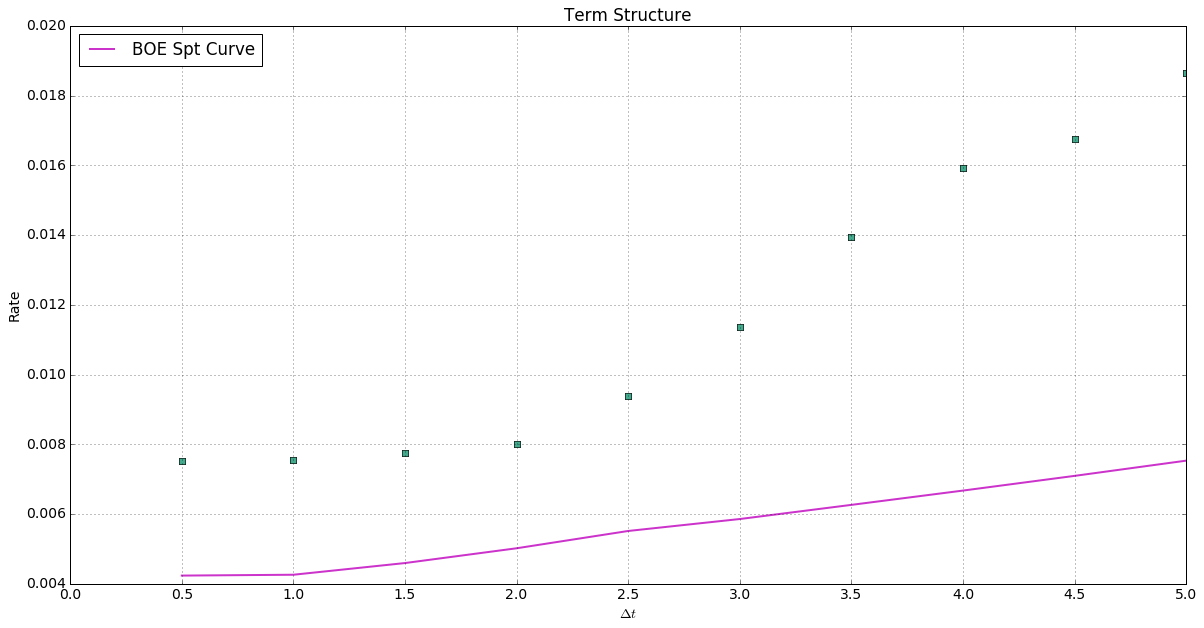

In [37]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
from numpy import linspace, array, arange, append, insert, percentile, mean
import app.CreditDefaultSwap as cds


# for colour cycling in graphs
from itertools import cycle
cycol = cycle('cmy').next

# set defaults for charts
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams['font.size'] = 14.0

# Counterparty A exposure (positive exposure)
def getExpectedExposureA(simData=array):
        expectedExposure = mean(array([sim.expA for sim in simData]), axis=0)
        return append(expectedExposure, 0.0)

# Counterparty B exposure (negative exposure)
def getExpectedExposureB(simData=array):
    expectedExposure = mean(array([sim.expB for sim in simData]), axis=0)
    return append(expectedExposure, 0.0)

def getPercentile(simData=array, p=float):
    ptile = percentile(array([sim.mtm for sim in simData]), q=p, axis=0)
    return ptile

def getExpectedMTM(simData=array):
    expected_mtm = mean(array([sim.mtm for sim in simData]), axis=0)
    return append(expected_mtm, 0.0)
    
def plotMTMChart(simData=array, title=str):
        for simulation in simData:
                x, y = timesteps, append(simulation.mtm, 0)
                # print y[0]
                plt.plot(x, y, 's', c=cycol(), lw=0.5, alpha=0.6)
        plt.plot(x, append(getPercentile(simData, 97.5), 0.0), c='#00FF00', lw=2, alpha=0.8, label='$97.5^th percentile$')
        plt.plot(x, append(getPercentile(simData, 2.5), 0.0), c='#0000FF', lw=2, alpha=0.8, label='$2.5^th percentile$')
        plt.plot(x, getExpectedMTM(simData), c='#FF0000', lw=2, alpha=0.8,label='Mean (Expected Exposure)')        
#         rate from B91 on ukois16_mdaily.xls
#         initRates_BOE_6m_plot = insert(initRates_BOE_6m, 0, 0.463126310164261)
#         # add to plot
#         # pyplot.plot(x, twoP5,c='#000000', lw=2, alpha=0.8)
#         pyplot.plot(x, append(ninetySevenP5, 0.0), c='#00CC00', lw=2, alpha=0.8)
#         pyplot.plot(x, append(twoP5, 0.0), c='#0000CC', lw=2, alpha=0.8)
#         pyplot.plot(x, append(expectedExposure, 0.0), c='#FF0000', lw=2, alpha=0.8)
        # pyplot.plot(x, append(initRates_BOE_6m,0.0), lw=2, alpha=0.8)
        # pyplot.plot(x, initRates, lw=2, alpha=0.8)
        plt.xlabel('$\Delta t$')
        plt.xticks(timesteps)
        plt.title(title)
        plt.ylabel('Payment')
        plt.legend(loc='upper left')
        plt.grid()
        plt.show()
        
def plotTermStructure(simData=array, title=str):
        for simulation in simData:
                x, y = timesteps[1:], simulation.liborTable[9]
                # print y[0]
                plt.plot(x, y, 's', c=cycol(), lw=0.5, alpha=0.6)
                
#         rate from B91 on ukois16_mdaily.xls
#         initRates_BOE_6m_plot = insert(initRates_BOE_6m, 0, 0.463126310164261)
#         # add to plot
#         # pyplot.plot(x, twoP5,c='#000000', lw=2, alpha=0.8)
#         pyplot.plot(x, append(ninetySevenP5, 0.0), c='#00CC00', lw=2, alpha=0.8)
#         pyplot.plot(x, append(twoP5, 0.0), c='#0000CC', lw=2, alpha=0.8)
#         pyplot.plot(x, append(expectedExposure, 0.0), c='#FF0000', lw=2, alpha=0.8)
        # pyplot.plot(x, append(initRates_BOE_6m,0.0), lw=2, alpha=0.8)
        plt.plot(x, initRates_BOE_6m_scaled, lw=2, c=cycol(), alpha=0.8, label="BOE Spt Curve")
        plt.xlabel('$\Delta t$')
        plt.xticks(timesteps)
        plt.title(title)
        plt.ylabel('Rate')
        plt.legend(loc='upper left')
        plt.grid()
        plt.show()
        
plotTermStructure(simulation1000,'Term Structure')

#### The Expected exposure 

If we plug the 97.5th percentile in to the pricer we should get back the potential future exposure. We can see how this differs from the expected exposure and how that affects the final premium.


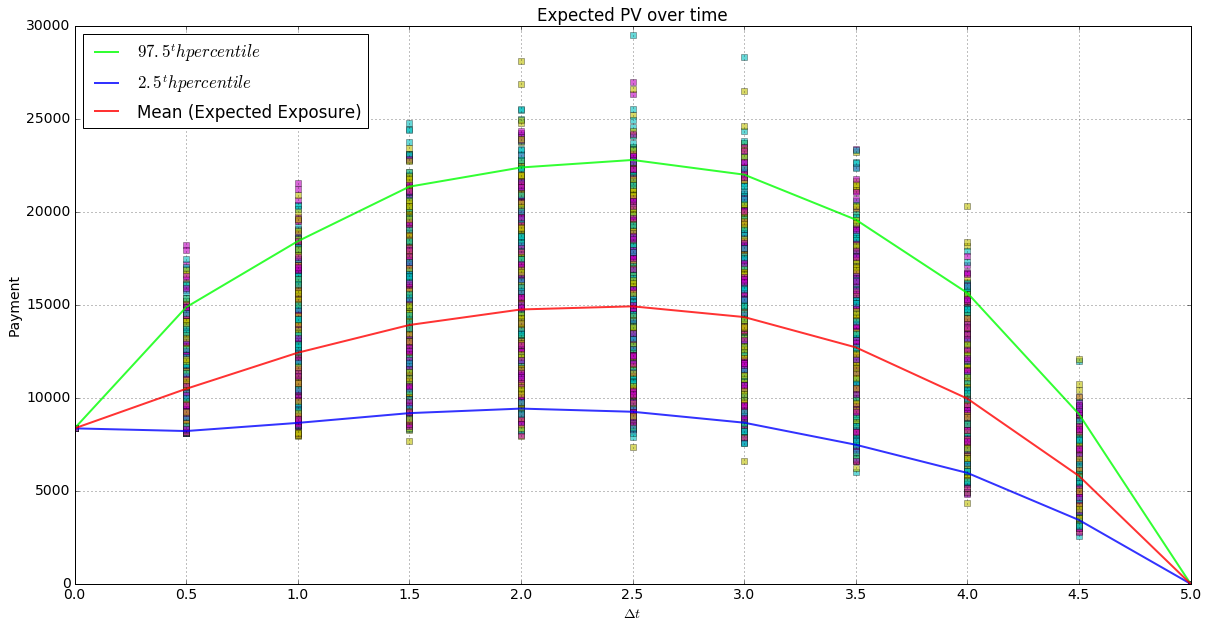

In [11]:
plotMTMChart(simulation1000, 'Expected PV over time')

ninetySevenPointFive = getPercentile(simulation1000, 97.5)

#mtm or EE for A
exposure = getExpectedExposureA(simulation1000)
mtm = getExpectedMTM(simulation1000)
cva = f.calcCVA(mtm, exposure)

#### Calculate CVA

We will use the formula below to calculate the CVA:

$CVA = \int_{0}^{T} (1-R)\ x \ EE(t) \ x \ dPD(t)$

In [21]:
exposure = f.getExpectedExposureA(simulation1000)

exposureB = f.getExpectedExposureB(simulation1000)

exposure97 = f.getPercentile(simulation1000, 97.5)

mtm = f.getExpectedMTM(simulation1000)

cvaA = f.calcCVA(mtm, exposure)
cvaB = f.calcCVA(mtm, exposureB)
cva97 = f.calcCVA(mtm, exposure97)

print "====="
print "CVA: ", cvaA
print "BVA: ", cvaB
print "CVA for 97.5 percentile: ", cva97

=====
CVA:  184.634942318
BVA:  0.0
CVA for 97.5 percentile:  281.562979539


For the exposure we use the max function to provide us with only positive values:

$E(t) = max(V(t),0)$

where v(t) is the Mark to Market value.

and $dPD(t)$ is provided by the implied survival and thus default probabilities described above.

We can then take the expected exposure, $EE(t)$, from the average in the simulations.

For the exposure we use the max function to provide us with only positive values:

$E(t) = max(V(t),0)$

where v(t) is the Mark to Market value.

and $dPD(t)$ is provided by the implied survival and thus default probabilities described above.

We can then take the expected exposure, $EE(t)$, from the average in the simulations.


#### Calculate BVA

$E(t) = min(V(t),0)$

where v(t) is the Mark to Market value.

# Conclusions

Credit Model pricing is particularly suited to computational methods since it can be a laborious process to get all the mechanics of the models in place. 

## Improvements
- expand to use more CUDA functions.
- speed up pricer, it should be able to cope with 1m simulations relatively easily.
- add some clocks to see how long it takes computationally
- integrate NAG into rng library
- add d3.js (https://d3js.org) charting library to python notebooks, to allow for interactive views on the plots.

### References

[1] _'The One Factor Libor Market Model Using Monte Carlo Simulation: An Empirical Investigation'_, Pena, di Sabatino,Ligato,Ventura,Bertagna. Dec 2010

[2] _'Advanced Quantitative Finance with C++'_, Pena. 2014

[3] _'Python for Finance'_, Yves Hilpisch. 2014

[4] _'emscriptem'_, http://kripken.github.io/emscripten-site/. - C++ to JavaScript compiler.

[5] _'VisPy'_, http://cyrille.rossant.net/compiler-data-visualization/

[3] _'Title'_, Author, (Mon YYYY)
